In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
import matplotlib as mpl
from matplotlib.ticker import LinearLocator

import scipy
from scipy.integrate import odeint, DOP853, solve_ivp
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import sklearn
import sklearn.decomposition
import umap
from sklearn.datasets import load_digits
from scipy.stats import special_ortho_group

import os, sys
currentdir = os.path.dirname(os.path.abspath(os.getcwd()))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, currentdir) 

C:\Users\abel_\anaconda3\envs\CIT_\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
def ReLU(x):
    return np.where(x<0,0,x)

def sigmoid(x):
    return 1/(1+np.exp(-x))

def get_theory_weights(N):
    #𝑤𝑖𝑗~ cos(𝜃𝑖 − 𝜃𝑗 )
    x = np.arange(0,N,1)
    row = np.cos(2*np.pi*x/N)
    W = scipy.linalg.circulant(row)
    return W

def relu_ode(t,x,W):
    return ReLU(np.dot(W,x)) - x 

def sigmoid_ode(t,x,W):
    return sigmoid(np.dot(W,x)) - x 

def tanh_ode(t,x,W):
    return np.tanh(np.dot(W,x)) - x 

In [101]:
# 2D Ring attractor

def ring_ode(t,x):
    r = x[0]
    return [r*(1-r), 0]

def ring_ode_xy(t,x):
    x1, x2 = x
    hypot = np.sqrt(x1**2+x2**2)
    theta = np.arctan2(x2, x1)
    return [hypot*(1-hypot)*np.cos(theta), hypot*(1-hypot)*np.sin(theta)]

def ring_ode_xy_globalpert(t,x,W):
    x1, x2 = x
    hypot = np.sqrt(x1**2+x2**2)
    theta = np.arctan2(x2, x1)
    return [hypot*(1-hypot)*np.cos(theta)+W[0,0]*x1+W[0,1]*x2, hypot*(1-hypot)*np.sin(theta)+W[1,0]*x1+W[1,1]*x2]

def bump_function(x, center=0, amplitude=1, b=1):
    x_ = x-center

    if x.ndim == 1:
        if np.linalg.norm(x_)<b:
            return amplitude*np.exp(b**2/(np.linalg.norm(x_)**2-b**2))
        else:
            return 0
    else:
        bump = np.zeros(x.shape[0])
        support = np.where(np.linalg.norm(x_, axis=1)<b)[0]
        bump[support] = amplitude*np.exp(b**2/(np.linalg.norm(x_[support], axis=1)**2-b**2))
        return bump


def ring_ode_xy_pert(t,x,center,theta_bump,amplitude,b):
    x1, x2 = x
    hypot = np.sqrt(x1**2+x2**2)
    theta = np.arctan2(x2, x1)
    vector_bump = bump_perturbation_2d(x, center, theta_bump, amplitude, b=b)
    return [hypot*(1-hypot)*np.cos(theta)+vector_bump[0], hypot*(1-hypot)*np.sin(theta)+vector_bump[1]]


    
def bump_perturbation_2d(x, center, theta, amplitude, b=1):
    """
    Perturbation is composed of parallel vector field 
    with the location given by center, 
    the norm of the vectors determined by a bump function
    and the orientation given by theta
    
    theta: orientation of perturbation
    implemented for 2-dimensional systems
    """
    vector_bump = np.array([1, 0])
    vector_bump = np.multiply(np.dot(vector_bump, get_rotation_matrix(theta)), bump_function(x, center=center, amplitude=amplitude, b=b))
    
    return vector_bump


#random local perturbation to vector field
#with random location (for ring network this should be constrained around the ring)
#with random orientation
#with random bump size
#maximal extent?

def get_rotation_matrix(theta):
    return np.array([[np.cos(theta), np.sin(theta)],[-np.sin(theta), np.cos(theta)]])

def bump_perturbation(x, center, theta, amplitude, b=1):
    """
    Perturbation is composed of parallel vector field 
    with the location given by center, 
    the norm of the vectors determined by a bump function
    and the orientation given by theta
    
    theta: orientation of perturbation
    implemented for 2-dimensional systems
    """
    vector_bump = np.tile(np.array([1, 0]),(x.shape[0],1))

    vector_bump = np.multiply(np.dot(vector_bump, get_rotation_matrix(theta)), bump_function(x, center=center, amplitude=amplitude, b=b).reshape((-1,1)))
    
    return vector_bump

In [197]:
from scipy.optimize import minimize

def ring_ode_xy_globalpert_speed(x):
    x1, x2 = x
    hypot = np.sqrt(x1**2+x2**2)
    theta = np.arctan2(x2, x1)
    return np.linalg.norm([hypot*(1-hypot)*np.cos(theta)+W[0,0]*x1+W[0,1]*x2, hypot*(1-hypot)*np.sin(theta)+W[1,0]*x1+W[1,1]*x2])



 final_simplex: (array([[0.94958126, 0.32782573],
       [0.94958131, 0.32782555],
       [0.94958155, 0.32782489]]), array([8.22201491e-09, 9.37040041e-09, 1.25085376e-08]))
           fun: 8.2220149077675e-09
       message: 'Optimization terminated successfully.'
          nfev: 152
           nit: 79
        status: 0
       success: True
             x: array([0.94958126, 0.32782573])

In [205]:
Nsamples = 1000
fxd_points = np.zeros((Nsamples,2))
for i in range(Nsamples):
    x0 = np.random.uniform(-1,1,2)
    res = minimize(ring_ode_xy_globalpert_speed, x0, method='Nelder-Mead', tol=1e-6)
    fxd_points[i,:] = res.x

In [217]:
u_fxd_points = np.unique(np.round(fxd_points, 4), axis=0)
u_fxd_points

array([[-0.9496, -0.3278],
       [-0.5983,  0.7806],
       [ 0.    ,  0.    ],
       [ 0.5983, -0.7806],
       [ 0.9496,  0.3278]])

In [218]:
# ring_ode_xy_globalpert(0,res.x,W)
fig=plt.figure(figsize=(5,5))
ax = fig.add_subplot()
plt.scatter(*u_fxd_points.T, color='b')
ax.set(xlim=(-2, 2), ylim=(-2, 2))
ax.set_xticks([])
ax.set_yticks([])

[]

[(-2.0, 2.0), (-2.0, 2.0)]

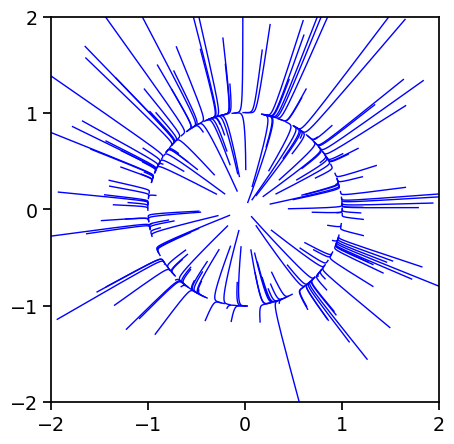

In [108]:
maxT = 25
t_bound = 10.
t = np.linspace(0, t_bound, 501)
W = np.random.normal(0, 1, (2,2))/100.

fig=plt.figure(figsize=(5,5))
ax = fig.add_subplot()
for i in range(200):
    r0 = np.random.uniform(0,2)
    theta0 = np.random.uniform(0,2*np.pi)
    x0 = np.random.normal(0,1,2)
    sol = solve_ivp(ring_ode_xy_globalpert, t_span=[0.,t_bound], y0=x0, dense_output=True, args=([W]))
    r = sol.sol(t)[0,:]
    theta = sol.sol(t)[1,:]
    # x1 = r*np.cos(theta)
    # x2 = r*np.sin(theta)
    x1 = sol.sol(t)[0,:]
    x2 = sol.sol(t)[1,:]
    ax.plot(x1, x2, color='blue');
    
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set(xlim=(-2, 2), ylim=(-2, 2))

In [298]:
t_bound = 400.
t = np.linspace(0, t_bound, Tpoints)
eps=0
r0=1.
# W = np.random.normal(0, 1, (2,2))/100.

Nsample = 200
Tpoints = 501
sols = np.zeros((Nsample, Tpoints, 2))
for i in range(Nsample):
    # for j in range(2):
    #     r0 = 1+(-1)**j*eps
        x10 = r0*np.cos(2*np.pi*i/Nsample)
        x20 = r0*np.sin(2*np.pi*i/Nsample)
        sol = solve_ivp(ring_ode_xy_globalpert, t_span=[t[0], t[-1]], t_eval=t, y0=[x10,x20], args=([W]), dense_output=True)
        sols[i, ...] = sol.sol(t).T

In [299]:
extrasols = np.zeros((Nsample, Tpoints, 2))
for i in range(Nsample):
    x10, x20 = u_fxd_points[2,:] + np.random.uniform(-1,1,2)/1000.
    sol = solve_ivp(ring_ode_xy_globalpert, t_span=[t[0], t[-1]], t_eval=t, y0=[x10,x20], args=([W]), dense_output=True)
    extrasols[i, ...] = sol.sol(t).T

In [336]:
u_fxd_points[[2]] , u_fxd_points[[1]]

def cartesian_to_spherical(x, y):
    r = np.sqrt(x**2 + y**2)  # radial distance
    theta = np.arctan2(y, x)    # angle in radians
    return r, theta

def spherical_to_cartesian(r, theta):
    x1 = r*np.cos(theta)  
    x2 = r*np.sin(theta)    
    return np.array([x1, x2])

t = np.linspace(0, -t_bound, Tpoints)

r, theta = cartesian_to_spherical(*u_fxd_points[[1]].T)
r *= 0.99
y0 = spherical_to_cartesian(r, theta)
sol_saddle1 = solve_ivp(ring_ode_xy_globalpert, t_span=[t[0], t[-1]], t_eval=t, y0=y0.squeeze(), args=([W]), dense_output=True)

r, theta = cartesian_to_spherical(*u_fxd_points[[3]].T)
r *= 0.99
y0 = spherical_to_cartesian(r, theta)
sol_saddle2 = solve_ivp(ring_ode_xy_globalpert, t_span=[t[0], t[-1]], t_eval=t, y0=y0.squeeze(), args=([W]), dense_output=True)

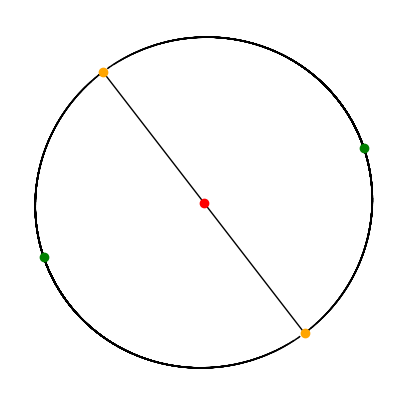

In [339]:
fig=plt.figure(figsize=(5,5))
ax = fig.add_subplot()
Tshift = 20
for i in range(Nsample):
    x1, x2 = sols[i,...].T
    ax.plot(x1[Tshift:], x2[Tshift:], color='k')
    x1, x2 = extrasols[i,...].T
    # ax.plot(x1[:], x2[:], color='purple')
ax.plot(*sol_saddle1.sol(t), color='k')
ax.plot(*sol_saddle2.sol(t), color='k')
ax.scatter(*u_fxd_points[[2]].T, color='r', zorder=10)
ax.scatter(*u_fxd_points[[1,3]].T, color='orange', zorder=10)
ax.scatter(*u_fxd_points[[0,4]].T, color='green', zorder=10)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
axis_max = 1.15
ax.set(xlim=(-axis_max, axis_max), ylim=(-axis_max, axis_max));
plt.axis('off');
plt.savefig(currentdir+"/Stability/figures/ringattractor_globalpert_5.pdf", bbox_inches="tight")
plt.savefig(currentdir+"/Stability/figures/ringattractor_globalpert_5.png", bbox_inches="tight")

W_5fixedpoints = np.array([[ 0.00017132,  0.01276055],[ 0.00574708, -0.01207038]])

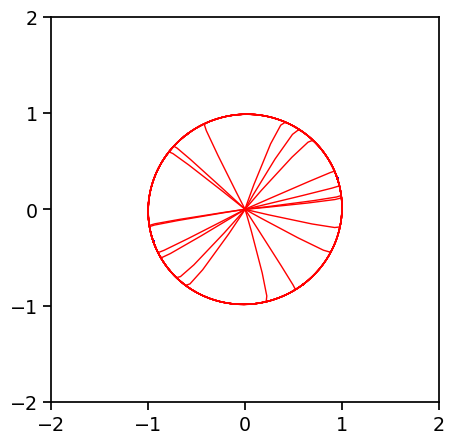

In [264]:
t_bound = 1000.
eps=0
# W = np.random.normal(0, 1, (2,2))/100.

fig=plt.figure(figsize=(5,5))
ax = fig.add_subplot()

for i in range(u_fxd_points.shape[0]):
    x10, x20 = u_fxd_points[i,:]

    t = np.linspace(0, t_bound, 501)
    for j in range(20):
        x10, x20 = u_fxd_points[i,:] + np.random.uniform(-1,1,2)/1000.
        sol = solve_ivp(ring_ode_xy_globalpert, t_span=[t[0], t[-1]], t_eval=t, y0=[x10,x20], args=([W]), dense_output=True)
        x1, x2 = sol.sol(t)[0,:], sol.sol(t)[1,:]
        ax.plot(x1[:], x2[:], color='r')
        # ax.scatter(x10, x10, color='g', s=.5)
        ax.scatter(x1[-1], x2[-1], color='b', s=.5)
    
    # t = np.linspace(0, -t_bound, 501)
    # sol = solve_ivp(ring_ode_xy_globalpert, t_span=[t[0], t[-1]], t_eval=t, y0=[x10,x20], args=([W]), dense_output=True)
    # x1, x2 = sol.sol(t)[0,:], sol.sol(t)[1,:]
    # ax.plot(x1[:], x2[:], color='r')
    # ax.scatter(x1[-1], x2[-1], color='b', s=.5)

    
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set(xlim=(-2, 2), ylim=(-2, 2));

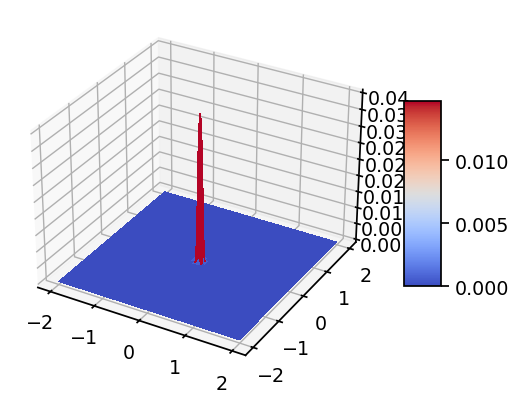

In [82]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X = np.arange(-2, 2, 0.01)
Y = np.arange(-2, 2, 0.01)
X, Y = np.meshgrid(X, Y)
Z = bump_function(np.array([X.flatten(),Y.flatten()]).T, amplitude=.1, b=.1).reshape((X.shape[0],X.shape[0]))
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

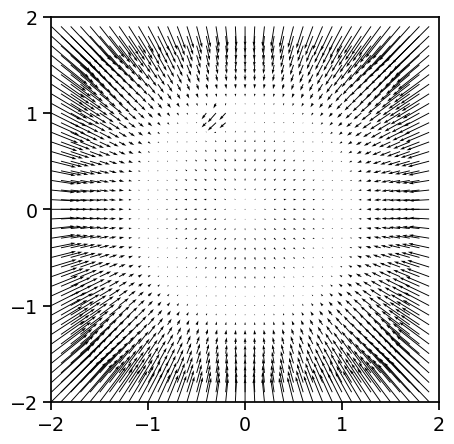

In [83]:
amplitude = .3
theta = np.random.uniform(0,2*np.pi)
eps = .1
center = np.random.normal(0, 1, 2)
center /= np.linalg.norm(center)
b = .2

w = 2.
X = np.arange(-2, 2, 0.1)
Y = np.arange(-2, 2, 0.1)
X, Y = np.meshgrid(X, Y)
U, V = bump_perturbation(np.array([X.flatten(),Y.flatten()]).T, center=center, theta=theta, amplitude=amplitude, b=b).T
U += ring_ode_xy(0,np.array([X.flatten(),Y.flatten()]))[0]/10.
V += ring_ode_xy(0,np.array([X.flatten(),Y.flatten()]))[1]/10.
speed = np.log(np.sqrt(U**2 + V**2))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.quiver(X, Y, U, V, scale=1/amplitude)

ax.set(xlim=(-w, w), ylim=(-w, w))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

In [84]:
# U, V = ring_ode_xy(0,np.array([X.flatten(),Y.flatten()]))
# U = U.reshape((X.shape[0], X.shape[0]))
# V = V.reshape((X.shape[0], X.shape[0]))

# UV = bump_perturbation(np.array([X.flatten(),Y.flatten()]).T, center=center, theta=theta, amplitude=amplitude, b=b).reshape((2, X.shape[0], X.shape[0]))
# U += UV[0]
# V += UV[1]
# speed = np.log(np.sqrt(U**2 + V**2))

# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# # normi = mpl.colors.Normalize(vmin=-6, vmax=1)
# strm = ax.streamplot(X, Y, U, V, density=.6, broken_streamlines=False, color=speed)
# cbar = fig.colorbar(strm.lines)
# cbar.ax.set_ylabel('log(speed)', rotation=90, labelpad=15)
# ax.set(xlim=(-w, w), ylim=(-w, w))
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# ax.yaxis.set_major_locator(MaxNLocator(integer=True))
# ax.set_xlabel("$H_1$")
# ax.set_ylabel("$H_2$");

[(-2.0, 2.0), (-2.0, 2.0)]

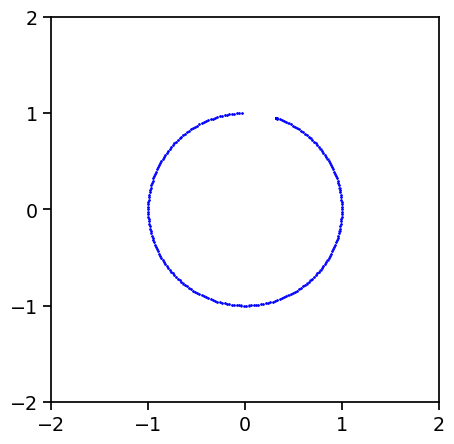

In [96]:
t_bound = 10.
t = np.linspace(0, 2*t_bound, 501)

amplitude = .1
theta = np.random.uniform(0,2*np.pi)
eps = .05
center = np.random.normal(0, 1, 2)
center /= np.linalg.norm(center)
# theta = np.arctan2(center[1], center[0])-np.pi #maintains circle attractor!
b = .2

fig=plt.figure(figsize=(5,5))
ax = fig.add_subplot()

Nsample = 250
for i in range(Nsample):
    #random
    # r0 = np.random.uniform(0,2)
    # theta0 = np.random.uniform(0,2*np.pi)
    # x0 = np.random.normal(0,1,2)
    
    for j in range(2):
        r0 = 1+(-1)**j*eps
        x1 = r0*np.cos(2*np.pi*i/Nsample)
        x2 = r0*np.sin(2*np.pi*i/Nsample)
        sol = solve_ivp(ring_ode_xy_pert, t_span=[t[0], t[-1]], t_eval=t, y0=[x1,x2], args=(center, theta, amplitude, b), dense_output=True)
        x1 = sol.sol(t)[0,:]
        x2 = sol.sol(t)[1,:]
        ax.scatter(x1[-1], x2[-1], color='b', s=.5)
        # ax.plot(x1, x2, color='r')
    
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set(xlim=(-2, 2), ylim=(-2, 2))
# plt.savefig(currentdir+"/Stability/figures/ringattractor_bumppert.pdf", bbox_inches="tight")
# plt.savefig(currentdir+"/Stability/figures/ringattractor_bumppert.png", bbox_inches="tight")

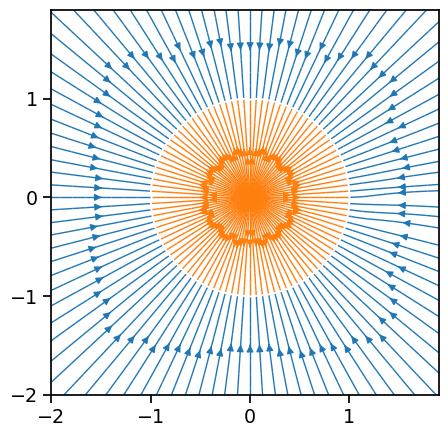

In [292]:
#starting points
thetas = np.arange(0,2*np.pi,np.pi/50)
eps = .01
r0 = 1+eps
x1 = np.cos(thetas)
x2 = np.sin(thetas)


fig=plt.figure(figsize=(5,5))
ax = fig.add_subplot()
start_points = np.array([(1+eps)*x1,(1+eps)*x2]).T
ax.streamplot(X, Y, U, V, broken_streamlines=False, integration_direction='backward', start_points=start_points)
start_points = np.array([(1-eps)*x1,(1-eps)*x2]).T
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.streamplot(X, Y, U, V, broken_streamlines=False, integration_direction='backward', start_points=start_points)
plt.savefig(currentdir+"/Stability/figures/ringattractor_bumppert_streamback.pdf", bbox_inches="tight")
plt.savefig(currentdir+"/Stability/figures/ringattractor_bumppert_streamback.png", bbox_inches="tight")

## BISWAS

#### Theory

In [3]:
N=8
x = np.arange(0,N+1,1.)
row = np.cos(2*np.pi*x/N-np.pi/2.)
plt.plot(row);

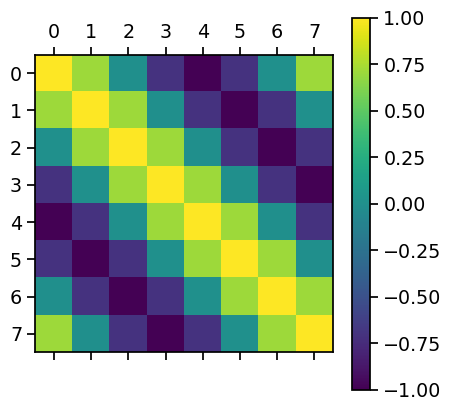

In [119]:
N=8
W = get_theory_weights(N)
plt.matshow(W);
plt.colorbar()

In [120]:
eps = np.random.uniform(-1,1,(N,N))/1000

In [134]:
maxT = 25
t_bound = 10.
t = np.linspace(0, t_bound, 501)
y0 = np.random.uniform(0,1,N)
sol = solve_ivp(tanh_ode, t_span=[0.,10.], y0=y0, args=([W+eps]),dense_output=True)

array([[ 0.2971083 ,  0.2931029 ,  0.28927918, ...,  0.96173458,
         0.96174698,  0.96175929],
       [ 0.7209741 ,  0.71522663,  0.71000016, ...,  0.99982086,
         0.99982157,  0.99982229],
       [ 0.94436537,  0.93565962,  0.9275745 , ...,  0.99984137,
         0.99984168,  0.99984199],
       ...,
       [ 0.7100311 ,  0.6874347 ,  0.66487927, ..., -0.99972789,
        -0.99973035, -0.99973283],
       [ 0.22748951,  0.21300068,  0.19835001, ..., -0.99976582,
        -0.99976755, -0.99976931],
       [ 0.8234105 ,  0.80081681,  0.77835049, ..., -0.96272072,
        -0.96271934, -0.96271806]])

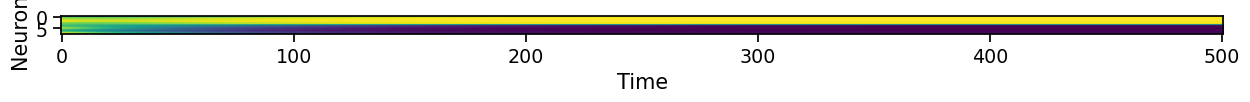

In [136]:
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 1})
fig, axs = plt.subplots(1, 1, figsize=(15, 8), sharex=True, sharey=True)
axs.imshow(sol.sol(t))
axs.set_xlabel("Time")
axs.set_ylabel("Neurons");

plt.savefig(currentdir+"/Stability/figures/ringattractor_dynamics.pdf", bbox_inches="tight")
plt.savefig(currentdir+"/Stability/figures/ringattractor_dynamics.png", bbox_inches="tight")

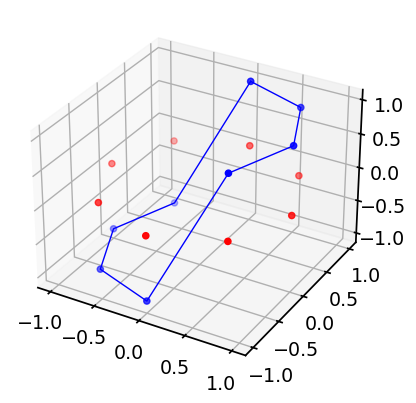

In [140]:
fig=plt.figure(1)
plt.clf()
ax = fig.add_subplot(projection='3d')
theta = np.linspace(0, 2*np.pi, N+1)
x = np.sin(theta)
y = np.cos(theta)
state_1p = np.zeros(N+1)
state_1p[:-1] = sol.sol(t)[:,-1]
state_1p[-1] = state_1p[0]
ax.scatter(x, y, state_1p, color='blue') 
ax.plot(x, y,    state_1p, color='blue') 
ax.scatter(x, y, np.zeros(N+1), color='red')


plt.savefig(currentdir+"/Stability/figures/ring_activity.pdf", bbox_inches="tight")
plt.savefig(currentdir+"/Stability/figures/ring_activity.png", bbox_inches="tight")
plt.show()

In [143]:
Npoints = 1000
eps = 0*np.random.uniform(-1,1,(N,N))/10.
sols = np.zeros((Npoints, t.shape[0], N))
for i in range(Npoints):
    y0 = np.random.uniform(0,1,N)
    sol = solve_ivp(tanh_ode, t_span=[0.,10.], y0=y0, args=([W+eps]),dense_output=True)
    sols[i,...] = sol.sol(t).T

In [144]:
fig=plt.figure(1)
plt.clf()
ax = fig.add_subplot(projection='3d')
theta = np.linspace(0, 2*np.pi, N+1)
x = np.sin(theta)
y = np.cos(theta)
for i in range(100):
    sol = sols[i]
    state_1p = np.zeros(N+1)
    state_1p[:-1] = sol[-1]
    state_1p[-1] = state_1p[0]
    ax.scatter(x, y, state_1p, color='blue') 
    ax.plot(x, y,    state_1p, color='blue') 
ax.scatter(x, y, np.zeros(N+1), color='red')
plt.show()

In [151]:
n_components = 2

N=80
W = get_theory_weights(N)
plt.matshow(W);
plt.colorbar()

In [174]:
Npoints = 1000
t_bound = 50
t = np.linspace(0, t_bound, 1001)
sols = np.zeros((Npoints, t.shape[0], N))
for i in range(Npoints):
    y0 = np.random.uniform(0,1,N)
    sol = solve_ivp(tanh_ode, t_span=[0.,t_bound], y0=y0, args=([W]), dense_output=True)
    sols[i,...] = sol.sol(t).T

eps = np.random.uniform(-1,1,(N,N))/1.
epssols = np.zeros((Npoints, t.shape[0], N))
for i in range(Npoints):
    y0 = np.random.uniform(0,1,N)
    sol = solve_ivp(tanh_ode, t_span=[0.,t_bound], y0=y0, args=([W+eps]), dense_output=True)
    epssols[i,...] = sol.sol(t).T

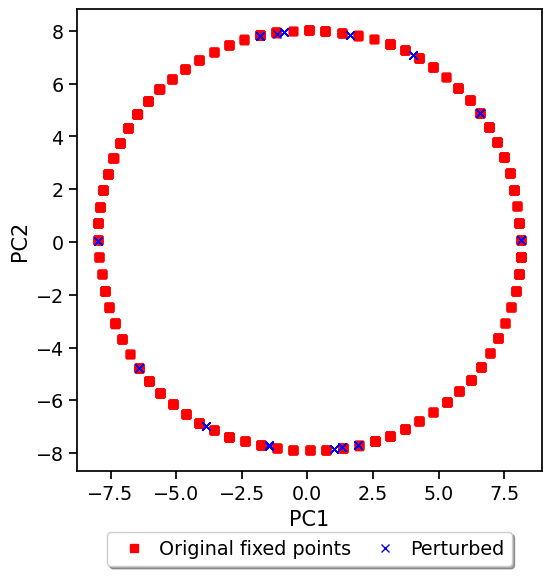

In [175]:
pca = sklearn.decomposition.PCA(n_components=n_components)
X_proj2 = pca.fit_transform(sols[:,-1,:]) 
Xeps_proj2 = pca.transform(epssols[:,-1,:]) 

plt.figure(figsize=(5,5))
plt.plot(X_proj2[:,0], X_proj2[:,1], 'rs', label="Original fixed points")

plt.plot(Xeps_proj2[:,0], Xeps_proj2[:,1], 'bx', label="Perturbed")
plt.xlabel("PC1")
plt.ylabel("PC2");

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11),
          fancybox=True, shadow=True, ncol=3, columnspacing=0.8, handletextpad=.3)

plt.savefig(currentdir+"/Stability/figures/ring_activity_pert_pca.pdf", bbox_inches="tight")
plt.savefig(currentdir+"/Stability/figures/ring_activity_pert_pca.png", bbox_inches="tight")
plt.show()

## Noorman

In [9]:
# symmetric cosine weight matrix W sym jk = JI + JE cos(theta_j - theta_K)
# where JE and JI respectively control the strength of the tuned and untuned components of recurrent connectivity between neurons with preferred headings theta_j and theta_k.

# For a network of size N , there are N 3 such “optimal” values of local excitation J*E

# The parameters (JI, JE) can be set such that this system will generate a population profile that qualitatively looks like a discretely sampled “bump” of activity.
# (JI, JE) are within the subset  \Omega = \OmegaJI\times\OmegaJE \subset (−1, 1) \times (2,1)

def get_noorman_symmetric_weights(N, J_I = 1, J_E = 1):
    # W sym jk = JI + JE cos(theta_j - theta_K)
    x = np.arange(0,N,1)
    row = J_I + J_E*np.cos(2*np.pi*x/N)
    W = scipy.linalg.circulant(row)
    return W


# W asym jk =sin(theta_j - theta_k)
def get_noorman_asymmetric_weights(N):
    # W asym jk =sin(theta_j - theta_k)
    x = np.arange(0,N,1)
    row = np.sin(2*np.pi*x/N)
    W = scipy.linalg.circulant(row)
    return W


In [10]:
# we will take phi(·) to be threshold linear

def v_in(t):
    return 0

def noorman_ode(t,x,tau,transfer_function,W_sym,W_asym,c_ff,N):
    """Differential equation of head direction network in Noorman et al., 2022. 
    tau: integration constant
    transfer_function: each neuron transforms its inputs via a nonlinear transfer function
    W_sym, W_asym: symmetric and asymmetric weight matrices
    v_in: input
    c_ff: a constant feedforward input to all neurons in the network
    N: number of neurons in the network
    """

    return (-x + np.dot(W_sym+v_in(t)*W_asym, transfer_function(x))/N + c_ff)/tau

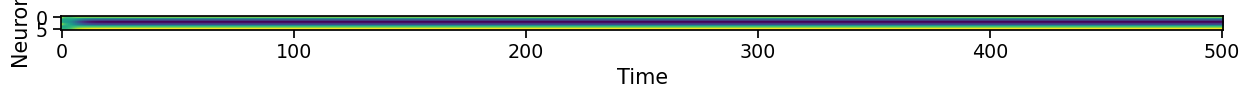

In [13]:
tau = .1
transfer_function = ReLU
N = 6
J_I = -2.4
J_E = 4
W_sym = get_noorman_symmetric_weights(N, J_I, J_E)
W_asym = get_noorman_asymmetric_weights(N)
c_ff = 1.

maxT = 25
t = np.linspace(0, maxT, 501)
y0 = np.random.uniform(0,1,N)

sol = solve_ivp(noorman_ode, y0=y0,  t_span=[0,maxT], args=tuple([tau, transfer_function, W_sym, W_asym, c_ff, N]),dense_output=True)

sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 1})
fig, axs = plt.subplots(1, 1, figsize=(15, 8), sharex=True, sharey=True)
axs.imshow(sol.sol(t))
axs.set_xlabel("Time")
axs.set_ylabel("Neurons");

In [14]:
Npoints = 1000
maxT = 25
t = np.linspace(0, maxT, 501)
y0 = np.random.uniform(0,1,N)
sols = np.zeros((Npoints, t.shape[0], N))
for i in range(Npoints):
    y0 = np.random.uniform(-.1,.1,N)
    sol = solve_ivp(noorman_ode, y0=y0,  t_span=[0,maxT], args=tuple([tau, transfer_function, W_sym, W_asym, c_ff, N]),dense_output=True)
    sols[i,...] = sol.sol(t).T

In [15]:
pca = sklearn.decomposition.PCA(n_components=n_components)
X_proj2 = pca.fit_transform(sols[:,-1,:]) 
theta=np.pi/10.
A = rotation_matrix(theta)
X_proj2 = np.dot(X_proj2,A)
# Xeps_proj2 = pca.transform(epssols[:,-1,:]) 

plt.figure(figsize=(6,6))
plt.plot(X_proj2[:,0], X_proj2[:,1], '.b', label="Original fixed points")

# plt.plot(Xeps_proj2[:,0], Xeps_proj2[:,1], 'bx', label="Perturbed")
plt.xlabel("PC1")
plt.ylabel("PC2");

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11),
          fancybox=True, shadow=True, ncol=3, columnspacing=0.8, handletextpad=.3)

# plt.savefig(currentdir+"/Stability/figures/ring_activity_pert_pca.pdf", bbox_inches="tight")
# plt.savefig(currentdir+"/Stability/figures/ring_activity_pert_pca.png", bbox_inches="tight")
# plt.show()

NameError: name 'n_components' is not defined

In [1169]:
m = np.max(sols)
m #round? what should the maximum be according to the paper?

x = np.arange(0, m, 0.01)
bumps = np.array([m-x,m*np.ones(x.shape),x,x-m,-m*np.ones(x.shape),-x])
for bump_i in range(bumps.shape[1]):
    plt.plot(bumps[:,bump_i])

In [1199]:
maxT = 20
t = np.linspace(0, maxT, 501)
y0 = np.random.uniform(0,1,N)
sols = np.zeros((x.shape[0], N, t.shape[0], N))
for bump_i in range(x.shape[0]):
    for support_j in range(N):
        y0 = np.roll(bumps[:,bump_i], support_j)
        sol = solve_ivp(noorman_ode, y0=y0,  t_span=[0,maxT], args=tuple([tau, transfer_function, W_sym, W_asym, c_ff, N]),dense_output=True)
        sols[bump_i,support_j,...] = sol.sol(t).T

In [1200]:
eps = np.random.uniform(-1,1,(N,N))/100.

In [1201]:
epssols = np.zeros((x.shape[0], N, t.shape[0], N))
for bump_i in range(x.shape[0]):
    for support_j in range(N):
        y0 = np.roll(bumps[:,bump_i], support_j) 
        sol = solve_ivp(noorman_ode, y0=y0,  t_span=[0,maxT], args=tuple([tau, transfer_function, W_sym+eps, W_asym, c_ff, N]),dense_output=True)
        epssols[bump_i,support_j,...] = sol.sol(t).T
        

In [1202]:
t = np.linspace(0, -2, 51)
back_epssols = np.zeros((x.shape[0], N, t.shape[0], N))
for bump_i in range(x.shape[0]):
    for support_j in range(N):
        y0 = np.roll(bumps[:,bump_i], support_j) 
        sol = solve_ivp(noorman_ode, y0=y0,  t_span=[0,t[-1]], t_eval=t, args=tuple([tau, transfer_function, W_sym+eps, W_asym, c_ff, N]),dense_output=True)
        back_epssols[bump_i,support_j,...] = sol.sol(t).T

<Figure size 500x500 with 0 Axes>

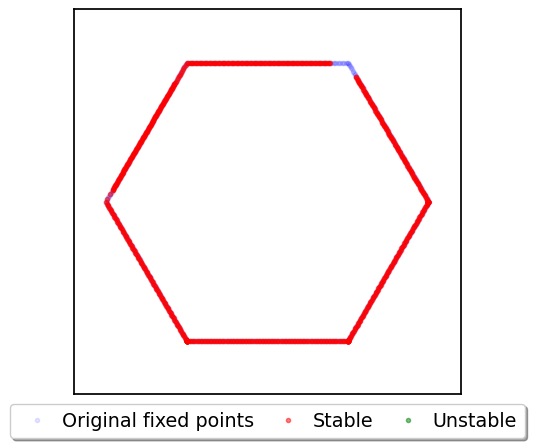

In [1203]:
N_points = bumps.shape[0]*bumps.shape[1]
sols = sols.reshape((N_points, -1, N))
epssols_flat = epssols.reshape((N_points, -1, N))
back_epssols_flat = back_epssols.reshape((N_points, -1, N))

pca = sklearn.decomposition.PCA(n_components=n_components)
X_proj2 = pca.fit_transform(sols[:,-1,:]) 
Xeps_proj2 = pca.transform(epssols_flat[:,-1,:]) 
Xbackeps_proj2 = pca.transform(back_epssols_flat[:,-1,:]) 
Xallbackeps_proj2  = pca.transform(back_epssols_flat[:,:25,:].reshape((-1,N))) 

plt.figure(figsize=(5,5))
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=True, sharey=True)
ax.plot(X_proj2[:,0], X_proj2[:,1], '.b', label="Original fixed points", alpha=0.1)
ax.plot(Xeps_proj2[:,0], Xeps_proj2[:,1], '.r', label="Stable", zorder=10, alpha=.5)
ax.plot(Xbackeps_proj2[:,0], Xbackeps_proj2[:,1], '.g', label="Unstable", zorder=10, alpha=.5)
# ax.plot(Xallbackeps_proj2[:,0], Xallbackeps_proj2[:,1], '.g', label="Unstable", zorder=10, alpha=.5)
ax.set(xlim=(-3, 3), ylim=(-3,3))

ax.set_xticks([])
ax.set_yticks([])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.),
          fancybox=True, shadow=True, ncol=3, columnspacing=0.8, handletextpad=.3)

# plt.savefig(currentdir+"/Stability/figures/noorman_ring_activity_pert_pca.pdf", bbox_inches="tight")
# plt.savefig(currentdir+"/Stability/figures/noorman_ring_activity_pert_pca.png", bbox_inches="tight")
# plt.show()

In [1098]:
def bump_perturbation(x, center, rotation_mat, amplitude, b=1):
    """
    Perturbation is composed of parallel vector field 
    with the location given by center, 
    the norm of the vectors determined by a bump function
    and the orientation given by theta
    
    x.shape = (Numberofpoints,N)
    theta: orientation of perturbation
    implemented for N-dimensional systems
    """
    N = x.shape[0]
    vector_bump = np.zeros(N)
    vector_bump[0] = 1.
    rotation_mat = special_ortho_group.rvs(N)
    vector_bump = np.dot(vector_bump, rotation_mat)
    vector_bump = np.multiply(vector_bump, bump_function(x, center=center, amplitude=amplitude, b=b))
    
    return vector_bump



In [1087]:
def noorman_ode_pert(t,x,tau,transfer_function,W_sym,W_asym,c_ff,N,center,rotation_mat,amplitude,b):
    """
    create ODE for Noorman ring attractor with a local bump perturbation
    center,rotation_mat,amplitude,b are set
    """
    vector_bump = bump_perturbation(x, center, rotation_mat, amplitude, b)
    noor = noorman_ode(t,x,tau,transfer_function,W_sym,W_asym,c_ff,N)
    return noor + vector_bump

def noorman_ode_Npert(t,x,tau,transfer_function,W_sym,W_asym,c_ff,N,Nbumps):
    """
    create ODE for Noorman ring attractor with Nbumps local bump perturbations
    for each bump: center,rotation_mat,amplitude,b are random
    """
    noorode = noorman_ode(t,x,tau,transfer_function,W_sym,W_asym,c_ff,N)
    for bi in range(Nbumps):
        bump_i = np.random.randint(bumps.shape[0]) 
        roll_j = np.random.randint(N)
        center = np.roll(bumps[:,bump_i], roll_j).copy()
        rotation_mat = special_ortho_group.rvs(N)
        amplitude = np.random.rand()
        b = np.random.rand()
        noorode += bump_perturbation(x, center, rotation_mat, amplitude, b)

    return noorode

In [1101]:
rotation_mat = special_ortho_group.rvs(N)
#create a random point along the ring attractor by 
#choosing a random bump
#and roll with it
bump_i = np.random.randint(bumps.shape[0]) 
roll_j = np.random.randint(N)
center = np.roll(bumps[:,bump_i], roll_j).copy()
amplitude = 1.
b = .5

In [1150]:
maxT = 20
t = np.linspace(0, maxT, 51)
sols = np.zeros((x.shape[0], N, t.shape[0], N))
for bump_i in range(x.shape[0]):
    for support_j in range(N):
        y0 = np.roll(bumps[:,bump_i], support_j)
        sol = solve_ivp(noorman_ode, y0=y0,  t_span=[0,maxT], t_eval=t, args=tuple([tau, transfer_function, W_sym, W_asym, c_ff, N]),dense_output=True)
        sols[bump_i,support_j,...] = sol.sol(t).T
        
epssols = np.zeros((x.shape[0], N, t.shape[0], N))
for bump_i in range(x.shape[0]):
    for support_j in range(N):
        y0 = np.roll(bumps[:,bump_i], support_j) 
        sol = solve_ivp(noorman_ode_pert, y0=y0,  t_span=[0,maxT], t_eval=t, args=tuple([tau, transfer_function, W_sym, W_asym, c_ff, N, center, rotation_mat, amplitude, b]),dense_output=True)
        epssols[bump_i,support_j,...] = sol.sol(t).T
        
t = np.linspace(0, -1, 51)
back_epssols = np.zeros((x.shape[0], N, t.shape[0], N))
for bump_i in range(x.shape[0]):
    for support_j in range(N):
        y0 = np.roll(bumps[:,bump_i], support_j) 
        sol = solve_ivp(noorman_ode_pert, y0=y0,  t_span=[0,-1], t_eval=t, args=tuple([tau, transfer_function, W_sym, W_asym, c_ff, N, center, rotation_mat, amplitude, b]),dense_output=True)
        back_epssols[bump_i,support_j,...] = sol.sol(t).T

<Figure size 500x500 with 0 Axes>

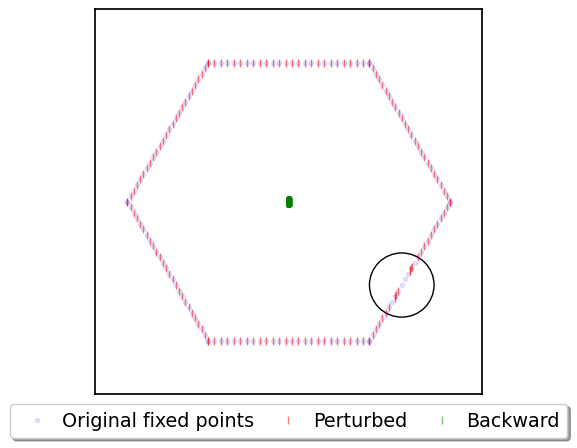

In [1157]:
sols = sols.reshape((-1,t.shape[0], N))
epssols_flat = epssols.reshape((-1,t.shape[0], N))
back_epssols_flat = back_epssols.reshape((-1,t.shape[0], N))

pca = sklearn.decomposition.PCA(n_components=n_components)
X_proj2 = pca.fit_transform(sols[:,-1,:]) 
Xeps_proj2 = pca.transform(epssols_flat[:,-1,:]) 
Xbackeps_proj2 = pca.transform(back_epssols_flat[:,-1,:]) 

plt.figure(figsize=(5,5))
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=True, sharey=True)
ax.plot(X_proj2[:,0], X_proj2[:,1], '.b', label="Original fixed points", alpha=0.1)
ax.plot(Xeps_proj2[:,0], Xeps_proj2[:,1], '|r', label="Perturbed", zorder=10, alpha=.5)
ax.plot(Xbackeps_proj2[:,0], Xbackeps_proj2[:,1], '|g', label="Backward", zorder=10, alpha=.5)
ax.set(xlim=(-3, 3), ylim=(-3,3))

ax.set_xticks([])
ax.set_yticks([])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.),
          fancybox=True, shadow=True, ncol=3, columnspacing=0.8, handletextpad=.3)

center_pca = pca.transform([center])[0]
circle = plt.Circle(center_pca, b, color='k', fill=False)
ax.add_patch(circle)

plt.savefig(currentdir+"/Stability/figures/noorman_ring_activity_localpert_bumpcircle.pdf", bbox_inches="tight")
plt.savefig(currentdir+"/Stability/figures/noorman_ring_activity_localpert_bumpcircle.png", bbox_inches="tight")

In [19]:
# circle_in_vectorspace = 

# #create points on hypersphere as:
# 1. take p=[1, 0, ... 0]
# 2. rotate point(s) along next axis ????


import math


def fibonacci_sphere(samples=1000):

    points = []
    phi = math.pi * (math.sqrt(5.) - 1.)  # golden angle in radians

    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2  # y goes from 1 to -1
        radius = math.sqrt(1 - y * y)  # radius at y

        theta = phi * i  # golden angle increment

        x = math.cos(theta) * radius
        z = math.sin(theta) * radius

        points.append((x, y, z))

    return points




def uniform_hypersphere_lattice(n_points, n_dim):
    """
    Generate a uniform lattice of points on an N-dimensional hypersphere.
    
    Parameters:
        n_points (int): The number of lattice points to generate.
        n_dim (int): The number of dimensions of the hypersphere.
    
    Returns:
        A numpy array of shape (n_points, n_dim) representing the lattice points.
    """
    points = np.zeros((n_points, n_dim))
    delta = 2.0 / n_points
    for i in range(n_points):
        r = 1
        phi = i * delta * 2 * np.pi
        x = r * np.cos(phi)
        y = r * np.sin(phi)
        points[i, 0] = x
        points[i, 1] = y
        for j in range(2, n_dim):
            points[i, j] = points[i, j-2] * np.cos(delta * np.pi) + \
                           points[i, j-1] * np.sin(delta * np.pi)
    return points

In [29]:
points = uniform_hypersphere_lattice(n_points=10**2, n_dim=2)
points
plt.scatter(*b*points.T)

NameError: name 'b' is not defined

In [1147]:
plt.figure(figsize=(5,5))
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=True, sharey=True)
ax.plot(X_proj2[:,0], X_proj2[:,1], '.b', label="Original fixed points", alpha=0.1)
ax.plot(Xeps_proj2[:,0], Xeps_proj2[:,1], '|r', label="Perturbed", zorder=10, alpha=.5)
ax.set_xticks([])
ax.set_yticks([])

ax.set(xlim=(center_pca[0]-2*b, center_pca[0]+2*b), ylim=(center_pca[1]-2*b, center_pca[1]+2*b))

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.),
          fancybox=True, shadow=True, ncol=3, columnspacing=0.8, handletextpad=.3)

plt.savefig(currentdir+"/Stability/figures/noorman_ring_activity_localpert_zoom.pdf", bbox_inches="tight")
plt.savefig(currentdir+"/Stability/figures/noorman_ring_activity_localpert_zoom.png", bbox_inches="tight")

<Figure size 500x500 with 0 Axes>

In [ ]:
back_epssols = np.zeros((x.shape[0], N, t.shape[0], N))
for bump_i in range(x.shape[0]):
    for support_j in range(N):
        y0 = epssols[bump_i,support_j,-1,:]
        sol = solve_ivp(noorman_ode_pert, y0=y0,  t_span=[0,-maxT], t_eval=t, args=tuple([tau, transfer_function, W_sym, W_asym, c_ff, N, center, rotation_mat, amplitude, b]),dense_output=True)
        back_epssols[bump_i,support_j,...] = sol.sol(t).T

In [ ]:
noorman_ode_pert